In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import  torch
import time
#TODO: remove
%load_ext tensorboard
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

torch.manual_seed(0)

In [2]:
def polynomial_fun(w, x):
    x = x.view(-1, 1)
    powers_of_x = x**torch.arange(len(w)).view(1, -1)
    y = torch.mm(powers_of_x, w)

    return y.squeeze()

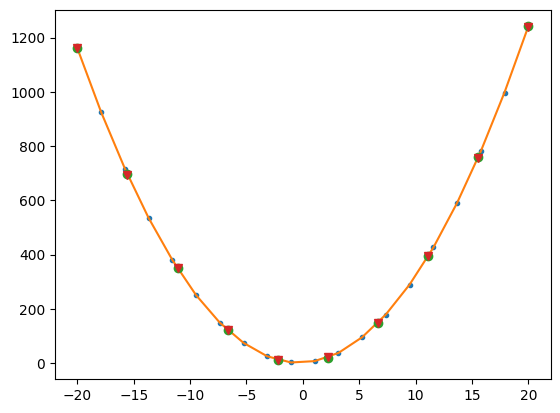

In [3]:

#implement task script 1

#1) Use polynomial_fun (𝑀 = 2, 𝐰 = [1,2,3]T) to generate a training set and a test set
w = torch.tensor([1, 2, 3], dtype=torch.float32).unsqueeze(1)
x_train = torch.linspace(-20, 20, 20)
x_test = torch.linspace(-20, 20, 10)
y_train = polynomial_fun(w, x_train)
y_test = polynomial_fun(w, x_test)
#observed t values with gauss noise 
t_train = y_train + 0.5 * torch.randn_like(y_train)
t_test = y_test + 0.5 * torch.randn_like(y_test)
fig, ax = plt.subplots()

ax.plot(x_train, y_train, '.')
ax.plot(x_train, t_train, '-')
ax.plot(x_test, y_test, 'o')
ax.plot(x_test, t_test, 'v')

In [25]:

def fit_polynomial_ls(x, t, M):
    x = x.view(-1, 1)
    t = t.view(-1, 1)

    powers_of_x = x**torch.arange(M+1, dtype=torch.float32)

    w = torch.linalg.lstsq(powers_of_x, t).solution

    return w.view(-1)

def fit_polynomial_sgd(x, t, M = 0, lr=1, miniBatchSize=10, print_freq=100, N_epochs=500):

    x = x.view(-1, 1)
    t = t.view(-1, 1)
    pow_of_x = x**torch.arange(M + 1).view(1, -1)
    x_mean = pow_of_x.mean(dim=0)
    x_std = pow_of_x.std(dim=0)
    #pow_of_x = (pow_of_x - x_mean) / x_std
    
    model = torch.nn.Linear(M + 1, 1, bias=False)
    #print('weights ', model.weight.data)
    #change to sgd
    opt = torch.optim.Adam(model.parameters(), lr = lr)
    #opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    #opt = torch.optim.RMSprop(model.parameters(), lr=lr)
    dataset = TensorDataset(pow_of_x, t)
    loader = DataLoader(dataset, batch_size=miniBatchSize, shuffle=True)
    mse_loss =  torch.nn.MSELoss()
    total_loss = 0.0
    num_batches = 0
    min_loss = torch.inf
    loss_diff_threshold = 1e-2
    max_norm = 1.0 
    losses = []
    grad_norms = []
    
    for epoch in range(N_epochs):
        for batch_x, batch_t in loader:
            #normalize batch x
            batch_x = (batch_x - batch_x.mean())/batch_x.std()
            opt.zero_grad()
            batch_y = model(batch_x)
            #print('output',  batch_y)
            #mean square loss
            loss = mse_loss(batch_y, batch_t)
            loss.backward() 
            #torch.nn.utils.clip_grad_value_(model.parameters(), 1)
            total_loss += loss.item()
            num_batches += 1
            opt.step()

        avg_loss = total_loss / num_batches
        losses.append(avg_loss)
        
        #doesn't d much 
        if abs(min_loss - loss.item()) < loss_diff_threshold:
            print('Early stopping at epoch {} with loss {}'.format(epoch+1, avg_loss))
            break;
        min_loss = avg_loss
        
        if (epoch + 1) % print_freq == 0:
            print('epoch {} loss {}'.format(epoch+1, avg_loss))
        total_loss = 0.0
        num_batches = 0
        
    #Plotting
    #TODO:remove

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('Loss per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(grad_norms)
    plt.title('Gradient norm per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient norm')
    plt.show()
                
    return model.weight.data.view(-1)

def descr_stat(powers_of_x, M):
    print("Descriptive Statistics for Polynomial Features")
    for power in range(M ):
        feature = powers_of_x[:, power]
        print(f"Feature x^{power}:")
        print(f"  Mean: {torch.mean(feature).item()}")
        print(f"  Std: {torch.std(feature).item()}")
        print(f"  Min: {torch.min(feature).item()}")
        print(f"  Max: {torch.max(feature).item()}")
        print(f"  25th percentile: {torch.quantile(feature, 0.25).item()}")
        print(f"  Median: {torch.median(feature).item()}")
        print(f"  75th percentile: {torch.quantile(feature, 0.75).item()}")
        print()

In [5]:
#:TODO remove 
xTrue = torch.arange(4, dtype=torch.float32)
w = torch.tensor([3, 4, 5, 6], dtype=torch.float32).unsqueeze(1)
yTrue = polynomial_fun(w, xTrue)

print(xTrue)
print(yTrue)

a = fit_polynomial_ls(xTrue, yTrue, M=3)
print(a)

tensor([0., 1., 2., 3.])
tensor([  3.,  18.,  79., 222.])
tensor([3.0000, 3.9999, 5.0000, 6.0000])


Training RMSE between the observed training data and the underlying “true” polynomial curve is  0.5488934516906738
Test RMSE between the observed training data and the underlying “true” polynomial curve in training data is  0.5181805491447449
For polynomial degree 2
Training RMSE between the LS values and the underlying “true” polynomial curve is 0.3698, and standard deviation is 0.3350
Test RMSE between the LS values and the underlying “true” polynomial curve is 0.3798, and standard deviation is 0.3648
For polynomial degree 3
Training RMSE between the LS values and the underlying “true” polynomial curve is 0.3699, and standard deviation is 0.3351
Test RMSE between the LS values and the underlying “true” polynomial curve is 0.3796, and standard deviation is 0.3645
For polynomial degree 4
Training RMSE between the LS values and the underlying “true” polynomial curve is 0.3700, and standard deviation is 0.3353
Test RMSE between the LS values and the underlying “true” polynomial curve is 

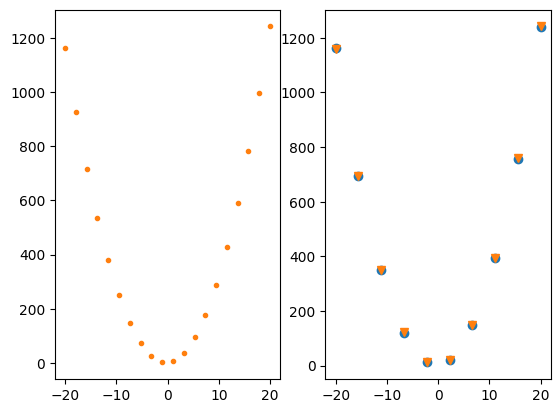

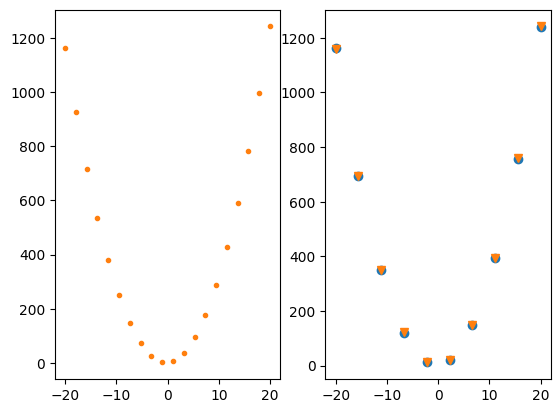

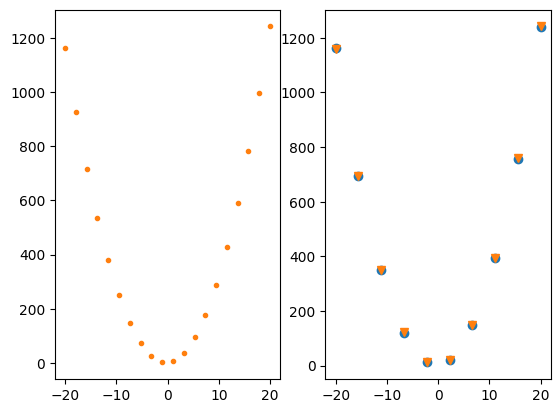

In [6]:

#2) Use fit_polynomial_ls (𝑀𝜖{2,3,4}) to compute the optimum weight 

M = torch.tensor([2,3,4])

#For each 𝑀, compute the predicted target values 𝑦̂ for all 𝑥 in both the training and test sets.
# pred_train = torch.zeros(len(x_train), len(M))
# pred_test = torch.zeros(len(x_test), len(M))
# rmse_train = torch.zeros(len(M))
# rmse_test = torch.zeros(len(M))
diff_obs_train = t_train - y_train
diff_obs_test = t_test - y_test
rmse_obs_train = torch.sqrt(torch.mean(torch.square(y_train - t_train)))
rmse_obs_test = torch.sqrt(torch.mean(torch.square(y_test - t_test)))
print('Training RMSE between the observed training data and the underlying “true” polynomial curve is ', rmse_obs_train.item())
print('Test RMSE between the observed training data and the underlying “true” polynomial curve in training data is ', rmse_obs_test.item())

for i, m in enumerate(M):
    w_hat = fit_polynomial_ls(x_train, t_train, m.item()).unsqueeze(1)
    pred_train = polynomial_fun(w_hat, x_train).squeeze()
    pred_test = polynomial_fun(w_hat, x_test).squeeze()
    
    #rmse
    diff_pred_train = pred_train - y_train
    diff_pred_test = pred_test - y_test
    
    rmse_train = torch.sqrt(torch.mean(torch.square(diff_pred_train)))
    rmse_test = torch.sqrt(torch.mean(torch.square(diff_pred_test)))
    std_dev_train = torch.std(diff_pred_train)
    std_dev_test = torch.std(diff_pred_test)
    
    rmse_train = torch.sqrt(torch.mean(torch.square(diff_pred_train)))
    rmse_test = torch.sqrt(torch.mean(torch.square(diff_pred_test)))
    std_dev_train = torch.std(diff_pred_train)
    std_dev_test = torch.std(diff_pred_test)
    
    print('For polynomial degree', m.item())
    print('Training RMSE between the LS values and the underlying “true” polynomial curve is {:.4f}, and standard deviation is {:.4f}'.format( rmse_train.item(), std_dev_train.item()))
    print('Test RMSE between the LS values and the underlying “true” polynomial curve is {:.4f}, and standard deviation is {:.4f}'.format( rmse_test.item(), std_dev_test.item()))

    #TODO:remove
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.plot(x_train, y_train, ',')
    ax1.plot(x_train, pred_train, '.')
    ax2.plot(x_test, y_test, 'o')
    ax2.plot(x_test, pred_test, 'v')

In [7]:
# Report, using printed messages, the mean (and standard deviation) in difference a) between
# the observed training data and the underlying “true” polynomial curve; and b) between the
# “LS-predicted” values and the underlying “true” polynomial curve.
#both test and train
diff_obs_train = t_train - y_train
diff_pred_train = pred_train - y_train
diff_obs_test = t_test - y_test
diff_pred_test = pred_test - y_test

sd_obs_train, mean_obs_train = torch.std_mean(diff_obs_train)
sd_pred_train, mean_pred_train = torch.std_mean(diff_pred_train)
sd_obs_test, mean_obs_test = torch.std_mean(diff_obs_test)
sd_pred_test, mean_pred_test = torch.std_mean(diff_pred_test)

print('Training Mean difference between the observed training data and the underlying “true” polynomial curve is ', mean_obs_train.item(), 'and standard diviation is', sd_obs_train.item() )
print('Training Mean difference between “LS-predicted” values and the underlying “true” polynomial curve is {:.3f}, and standard diviation: {:.3f}' .format(mean_pred_train.item(), sd_pred_train.item()) )
print('Test Mean difference between the observed training data and the underlying “true” polynomial curve in training data is ', mean_obs_test.item(), 'and standard diviation is', sd_obs_test.item())
print('Test  Mean difference between “LS-predicted” values and the underlying “true” polynomial curve is {:.3f}, and standard diviation: {:.3f}' .format(mean_pred_test.item(), sd_pred_test.item()) )

Training Mean difference between the observed training data and the underlying “true” polynomial curve is  0.17352184653282166 and standard diviation is 0.5342719554901123
Training Mean difference between “LS-predicted” values and the underlying “true” polynomial curve is 0.174, and standard diviation: 0.335
Test Mean difference between the observed training data and the underlying “true” polynomial curve in training data is  0.025728512555360794 and standard diviation is 0.5455365180969238
Test  Mean difference between “LS-predicted” values and the underlying “true” polynomial curve is 0.158, and standard diviation: 0.363


epoch 100 loss 61946.658203125
epoch 200 loss 10348.88037109375
epoch 300 loss 4828.123779296875
epoch 400 loss 14695.1630859375
epoch 500 loss 29190.0078125


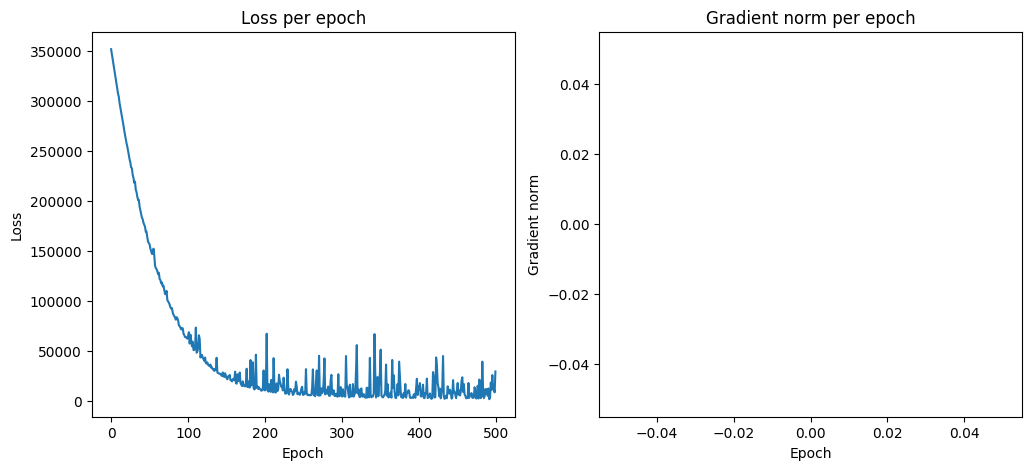

elapsed time for fit_polynomial_sgd: 1.16 seconds
For polynomial degree  2
Training Mean absolute difference between the “SGD-predicted” values and the underlying “true” polynomial curve is 361.436, and standard deviation is 225.256
Test Mean absolute difference between the “SGD-predicted” values and the underlying “true” polynomial curve is 361.436, and standard deviation is 225.256
Training RMSE  between the “SGD-predicted” values and the underlying “true” polynomial curve is 422.894, and standard deviation is 225.256
Test RMSE between the “SGD-predicted” values and the underlying “true” polynomial curve is 494.000, and standard deviation is 225.256
epoch 100 loss 331772.9375
epoch 200 loss 317575.796875
epoch 300 loss 301770.421875
epoch 400 loss 283825.53125
epoch 500 loss 269001.125


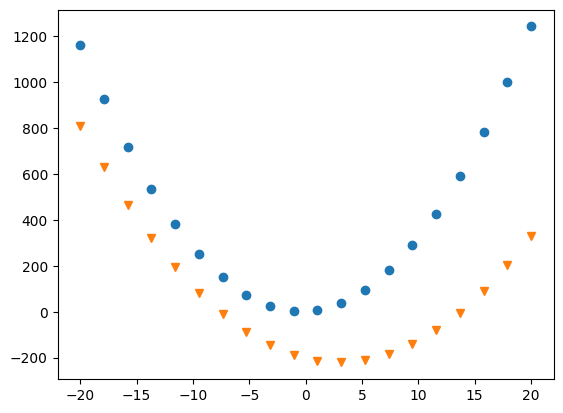

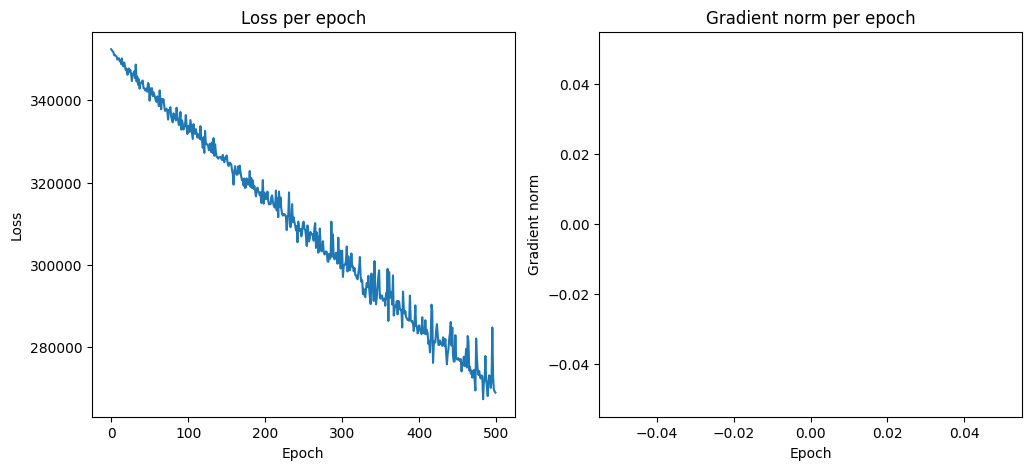

elapsed time for fit_polynomial_sgd: 1.19 seconds
For polynomial degree  3
Training Mean absolute difference between the “SGD-predicted” values and the underlying “true” polynomial curve is 241.636, and standard deviation is 181.095
Test Mean absolute difference between the “SGD-predicted” values and the underlying “true” polynomial curve is 241.636, and standard deviation is 181.095
Training RMSE  between the “SGD-predicted” values and the underlying “true” polynomial curve is 299.239, and standard deviation is 307.002
Test RMSE between the “SGD-predicted” values and the underlying “true” polynomial curve is 265.931, and standard deviation is 307.002
epoch 100 loss 43555.4306640625
epoch 200 loss 14374.91064453125
epoch 300 loss 16162.23046875
epoch 400 loss 13813.123046875
epoch 500 loss 13285.35693359375


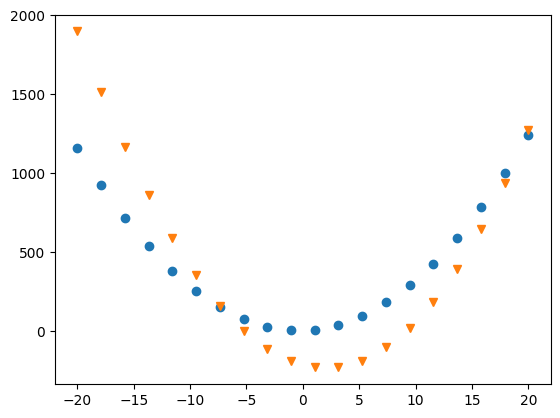

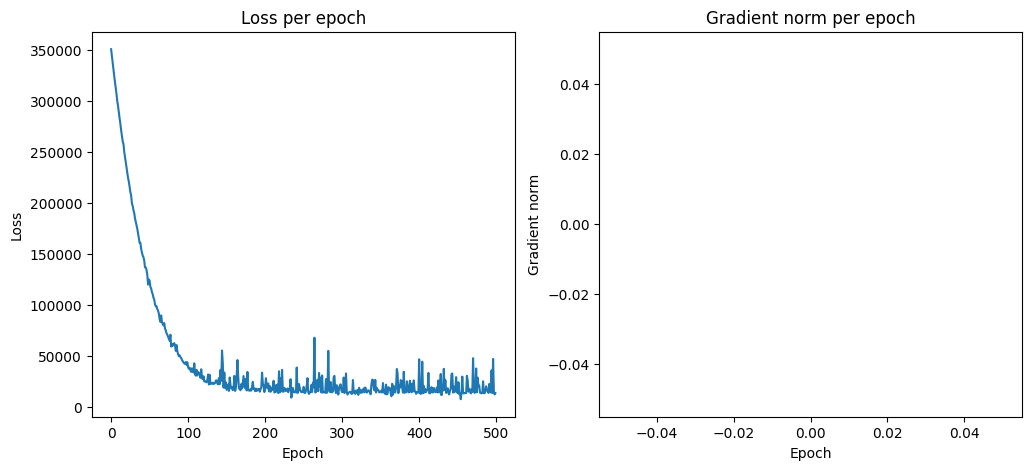

elapsed time for fit_polynomial_sgd: 1.13 seconds
For polynomial degree  4
Training Mean absolute difference between the “SGD-predicted” values and the underlying “true” polynomial curve is 552.131, and standard deviation is 453.096
Test Mean absolute difference between the “SGD-predicted” values and the underlying “true” polynomial curve is 552.131, and standard deviation is 453.096
Training RMSE  between the “SGD-predicted” values and the underlying “true” polynomial curve is 707.022, and standard deviation is 482.604
Test RMSE between the “SGD-predicted” values and the underlying “true” polynomial curve is 768.710, and standard deviation is 482.604


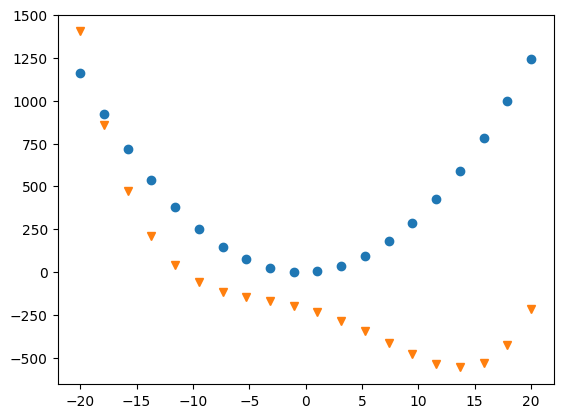

In [26]:
#Use fit_polynomial_sgd (𝑀𝜖{2,3,4}) to optimise the weight vector 𝐰̂ using the training set.
# For each 𝑀, compute the predicted target values 𝑦̂ for all 𝑥 in both the training and test sets.
#  Report, using printed messages, the mean (and standard deviation) in difference between the
# “SGD-predicted” values and the underlying “true” polynomial curve
# Normalize x_train and x_test
x_train_norm = (x_train - x_train.mean()) / x_train.std()
x_test_norm = (x_test - x_test.mean()) / x_test.std()
for i, m in enumerate(M):
    t0 = time.time()
    w_hat_opimized = fit_polynomial_sgd(x_train, t_train, m.item()).unsqueeze(1)
    t1 = time.time()
    print("elapsed time for fit_polynomial_sgd: %.2f seconds" % (t1-t0))
    #training
    pred_train_opt = polynomial_fun(w_hat_opimized, x_train_norm).squeeze()
    
    #test
    pred_test_opt = polynomial_fun(w_hat_opimized, x_test_norm).squeeze()
    
    #TODO: remove all plots
    fig, ax = plt.subplots()
    ax.plot(x_train, t_train, 'o')
    ax.plot(x_train, pred_train_opt, 'v')
    
    #polynomial degree
    print('For polynomial degree ', m.item())
    #mean difference 
    std_difference_tr, mean_difference_tr = torch.std_mean(torch.abs(pred_train_opt - y_train))
    std_difference_te, mean_difference_te = torch.std_mean(torch.abs(pred_train_opt - y_train))
    print('Training Mean absolute difference between the “SGD-predicted” values and the underlying “true” polynomial curve is {:.3f}, and standard deviation is {:.3f}'.format( mean_difference_tr.item(), std_difference_tr.item()))
    print('Test Mean absolute difference between the “SGD-predicted” values and the underlying “true” polynomial curve is {:.3f}, and standard deviation is {:.3f}'.format( mean_difference_te.item(), std_difference_te.item()))
    
    #rmse
    diff_pred_train_opt = pred_train_opt - y_train
    diff_pred_test_opt = pred_test_opt - y_test
    rmse_train_opt= torch.sqrt(torch.mean(torch.square(diff_pred_train_opt)))
    rmse_test_opt= torch.sqrt(torch.mean(torch.square(diff_pred_test_opt)))
    std_dev_train_opt = torch.std(diff_pred_train_opt)
    std_dev_test_opt = torch.std(diff_pred_train_opt)
    print('Training RMSE  between the “SGD-predicted” values and the underlying “true” polynomial curve is {:.3f}, and standard deviation is {:.3f}'.format( rmse_train_opt.item(), std_dev_train_opt.item()))
    print('Test RMSE between the “SGD-predicted” values and the underlying “true” polynomial curve is {:.3f}, and standard deviation is {:.3f}'.format( rmse_test_opt.item(), std_dev_test_opt.item()))

#0-15 for M 2, 3
#15-30 M 4
#loss approaching 0